# Tutorial on customizing unit models in WaterTAP
Demonstration how to modify existing unit models at flowsheet level

## Dependencies
* Python - Programming language
* Pyomo - Python package for equation-oriented modeling
* IDAES - Python package extending Pyomo for flowsheet modeling
* WaterTAP - Unit models

## Demonstration structure 
* Setting up basic RO flowsheet
* Replace a fixed variable with an equation to study impact of variable performance metrics
* Replace existing constraint with a new one for compartive analysis  
* Replace a fixed cost with variable cost based on operating condition 

## Flowsheet considered in the example
<img src="RO_flowsheet.png" width="500" height="200">

### Import key modules

In [111]:
## Import core components 
# Pyomo cor ecomponents
from pyomo.environ import (Param,Var, Constraint, TransformationFactory, Reals,    ConcreteModel,
    value,assert_optimal_termination,
    units as pyunits)
from pyomo.network import Arc
# Ideas core comoponents
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.solvers import get_solver
from idaes.core.util.scaling import constraint_scaling_transform
from idaes.core.util.initialization import propagate_state
from idaes.models.unit_models import Feed, Product
# WaterTAP core components 
import watertap.property_models.seawater_prop_pack as properties
from watertap.unit_models.reverse_osmosis_1D import (
    ReverseOsmosis1D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.unit_models.pressure_changer import Pump


### Build the flowsheet

In [112]:

m = ConcreteModel()
# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)
# create seawater property model
m.fs.properties = properties.SeawaterParameterBlock()

# build feed
m.fs.feed = Feed(property_package=m.fs.properties)
m.fs.product = Product(property_package=m.fs.properties)
#build pump
m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.RO = ReverseOsmosis1D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
    transformation_scheme="BACKWARD",
    transformation_method="dae.finite_difference",
    finite_elements=10,
)
# connect feed to pump
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination = m.fs.pump.inlet)
#connect pump to RO unit
m.fs.pump_to_ro = Arc(source=m.fs.pump.outlet, destination = m.fs.RO.inlet)
# connect RO permeate to product
m.fs.ro_to_product = Arc(source=m.fs.RO.permeate, destination = m.fs.product.inlet)
TransformationFactory("network.expand_arcs").apply_to(m) 


### Set default values and calculate scaling factors for flowsheet   

In [113]:

m.fs.feed.properties[0].temperature.fix(273 + 25)                      # temperature (K)
m.fs.feed.properties[0].pressure.fix(101325)                           # pressure (Pa)
m.fs.feed.properties[0].flow_mass_phase_comp['Liq', 'H2O'].fix(0.965)  # mass flowrate of H2O (kg/s)
m.fs.feed.properties[0].flow_mass_phase_comp['Liq', 'TDS'].fix(0.035)  # mass flowrate of TDS (kg/s)
m.fs.feed.properties[0].conc_mass_phase_comp[...] # construct concentration props
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1/0.965,
    index=("Liq", "H2O"),
)
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1/0.035,
    index=("Liq", "TDS"),
)
# to help with initialization lets build OSM variable on feed block
# which we can use to guess operating pressure for RO unit and set pump pressure during initialization
m.fs.feed.properties[0].pressure_osm_phase[...]
# define pump defaults
m.fs.pump.efficiency_pump[0].fix(0.75)
# scale work and pressures for the pump
set_scaling_factor(m.fs.pump.control_volume.work, 1e-4)
set_scaling_factor(m.fs.pump.control_volume.properties_out[0].pressure, 1e-5)
set_scaling_factor(m.fs.pump.control_volume.properties_in[0].pressure, 1e-5)

# to help with initalization lets build OSM variable on pump outlet
# which we can use to guess operating pressure for RO unit 

# define RO default values for initialization 
# we opt to specify stage area, and inlet velocity
# unfixing width and area
# We also apply variable scaling as we set up each default parameters 

m.fs.RO.feed_side.velocity[0, 0].fix(0.1)

m.fs.RO.area.fix(100)
set_scaling_factor(m.fs.RO.area,1/50)
m.fs.RO.length.unfix()
set_scaling_factor(m.fs.RO.length, 0.1)
m.fs.RO.width.unfix()
set_scaling_factor(m.fs.RO.width, 0.1)

# we need to specify RO permeate pressure
m.fs.RO.permeate.pressure[0].fix(101325)
# we need to specify default values for default mass transport correlation
# and friction factor correlations 
m.fs.RO.feed_side.channel_height.fix(1 / 10 / 100)
m.fs.RO.feed_side.spacer_porosity.fix(0.9)

# Specify default A and B values, these are dfined in m/s at unit level. 
m.fs.RO.A_comp[0, "H2O"].fix(3 / (3600 * 1000 * 1e5))
m.fs.RO.B_comp[0, "TDS"].fix(0.15 / (3600 * 1000))

# calculate all the scailing factors 
calculate_scaling_factors(m)


2023-10-10 07:27:44 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.RO.feed_side.area


### Initialize feed and pump

In [114]:
solver = get_solver() # get solver
m.fs.feed.initialize(optarg=solver.options)
propagate_state(m.fs.feed_to_pump)
# get osmotic pressure
osmotic_feed_pressure=value(m.fs.feed.properties[0].pressure_osm_phase['Liq'])
print("Osmotic pressure is {} bar".format(osmotic_feed_pressure/1e5))
m.fs.pump.outlet.pressure[0].fix(osmotic_feed_pressure*1.5) 
m.fs.pump.initialize(optarg=solver.options)
propagate_state(m.fs.pump_to_ro)
m.fs.RO.initialize(optarg=solver.options)

2023-10-10 07:27:44 [INFO] idaes.init.fs.feed.properties: fs.feed.properties State Released.
2023-10-10 07:27:44 [INFO] idaes.init.fs.feed: Initialization Complete.
Osmotic pressure is 25.86985038210651 bar
2023-10-10 07:27:44 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2023-10-10 07:27:44 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
2023-10-10 07:27:44 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2023-10-10 07:27:44 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2023-10-10 07:27:44 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2023-10-10 07:27:44 [INFO] idaes.init.fs.RO.feed_side.properties: fs.RO.feed_side.properties State Released.
2023-10-10 07:27:45 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2023-10-10 07:27:45 [INFO

### Solve box problem

In [115]:

# Check degrees of freedom 
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
# Solve box problem at initialized state 
result =solver.solve(m, tee=True)
assert_optimal_termination(result)

# apply operating conditions and solve again
m.fs.pump.outlet.pressure[0].unfix()
m.fs.RO.recovery_vol_phase[0.0, "Liq"].fix(0.5)
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0

result =solver.solve(m, tee=True)
assert_optimal_termination(result)
# lets check current solution 
m.fs.RO.report()

We have 0 degrees of freedom and expect 0
ipopt-watertap: Ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical

### Explore relationship between salinity and opertating pressure

In [116]:
m.fs.feed.properties[0].flow_mass_phase_comp['Liq','TDS'].unfix()
print('Current concentration {}'.format(m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].value))
m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(35)

print(degrees_of_freedom(m))
assert degrees_of_freedom(m) == 0
concentrations = np.linspace(15,100,10)
pressures = []
for con in concentrations:
    m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(con)
    result =solver.solve(m, tee=False)
    assert_optimal_termination(result)
    pressures.append(m.fs.RO.inlet.pressure[0].value/1e5)


Current concentration 35.82617901849218
0


## Plot salinity effect on result

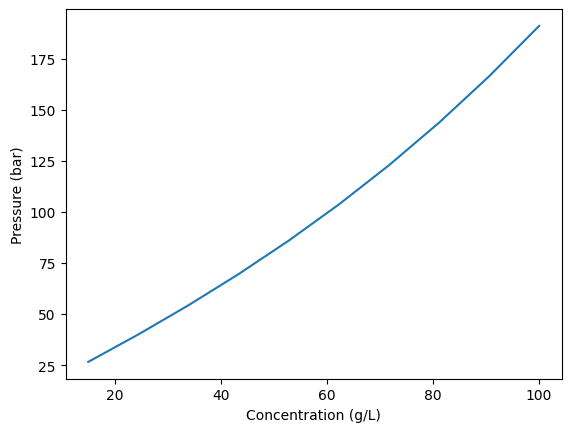

In [117]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(concentrations,pressures)
ax.set(xlabel='Concentration (g/L)',ylabel='Pressure (bar)')
plt.show()

## Add relationship between A parameter and inlet pressure to account for compaction effects    

For P<65 bar A=3 LMH/bar
For P>65 A = 3 *65/Inlet pressure

In [118]:
# Imports smooth min and smooth max functions
import idaes.core.util.math as idaesMath

# define our default A value 
m.fs.A_var_initial=Var(initialize=3.0)
m.fs.A_var_initial.fix()
set_scaling_factor(m.fs.A_var_initial, 1/m.fs.A_var_initial.value)

# define constraint that relates A value to P
m.fs.RO.A_pressure_constraint=(
    Constraint(expr=m.fs.RO.A_comp[0, "H2O"]*(3600 * 1000 * 1e5)==
    idaesMath.smooth_min(m.fs.A_var_initial,(m.fs.A_var_initial*(65*1e5/m.fs.RO.inlet.pressure[0])))))
    
m.fs.RO.A_comp[0,'H2O'].unfix()
m.fs.RO.A_pressure_constraint.pprint()

A_pressure_constraint : Size=1, Index=None, Active=True
    Key  : Lower : Body                                                                                                                                                                                                                                                         : Upper : Active
    None :   0.0 : 360000000000.0*fs.RO.A_comp[0.0,H2O] - 0.5*(fs.A_var_initial + fs.A_var_initial*(6500000.0/fs.RO.feed_side.properties[0.0,0.0].pressure) - ((fs.A_var_initial - fs.A_var_initial*(6500000.0/fs.RO.feed_side.properties[0.0,0.0].pressure))**2 + 1e-08)**0.5) :   0.0 :   True


### Verify that constraint produces expected outcomes 

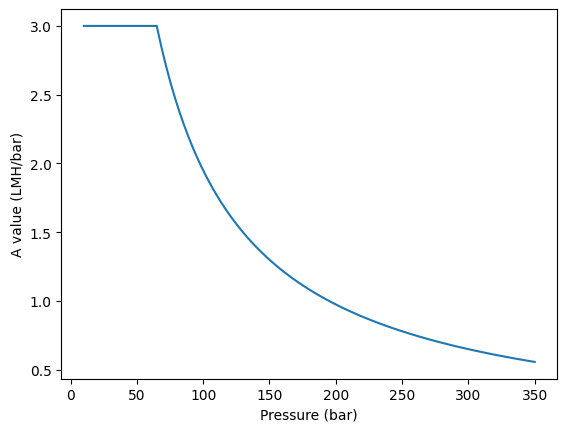

In [119]:
# import method to calcualte variable from constraint, allows evaluation of our constraint 
from pyomo.util.calc_var_value import calculate_variable_from_constraint
import numpy as np

pressures_for_testing=np.linspace(10,350,100)
A_vals=[]

for pressure in pressures_for_testing:
    m.fs.RO.inlet.pressure[0]=pressure*1e5 # needs to be in kPa
    calculate_variable_from_constraint(m.fs.RO.A_comp[0, "H2O"],m.fs.RO.A_pressure_constraint)
    A_vals.append(m.fs.RO.A_comp[0, "H2O"].value*(3600 * 1000 * 1e5))
fig, ax = plt.subplots()
ax.plot(pressures_for_testing,A_vals)
ax.set(xlabel='Pressure (bar)',ylabel='A value (LMH/bar)')
plt.show()

### Initalize A value at operating pressure and solve model with new constraint

In [120]:
# lets initialize the A value to our actual operating pressure 
m.fs.RO.inlet.pressure[0]=m.fs.pump.outlet.pressure[0].value 
# Calculate the unkonw value of A at specified pressure form our constraint 
calculate_variable_from_constraint(m.fs.RO.A_comp[0, "H2O"],m.fs.RO.A_pressure_constraint)


print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
# Solve model with new constraint
result =solver.solve(m, tee=False)
assert_optimal_termination(result)

# Explore how performance changes across feed concentrations 
concentrations = np.linspace(15,100,10)
pressures_with_a_loss = []
actual_a=[]
for con in concentrations:
    m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(con)
    result =solver.solve(m, tee=False)
    assert_optimal_termination(result)
    pressures_with_a_loss.append(m.fs.RO.inlet.pressure[0].value/1e5)
    actual_a.append(m.fs.RO.A_comp[0, "H2O"].value*(3600 * 1000 * 1e5))
    print("Solved con {}".format(con))


We have 0 degrees of freedom and expect 0
Solved con 15.0
Solved con 24.444444444444443
Solved con 33.888888888888886
Solved con 43.333333333333336
Solved con 52.77777777777778
Solved con 62.22222222222222
Solved con 71.66666666666667
Solved con 81.11111111111111
Solved con 90.55555555555556
Solved con 100.0


### Plot how operating pressure and A value changed during RO operation

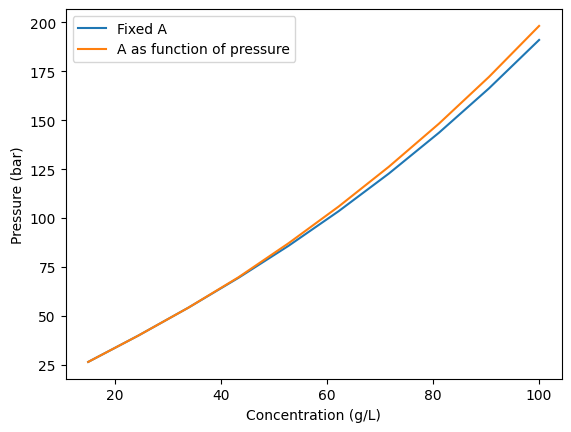

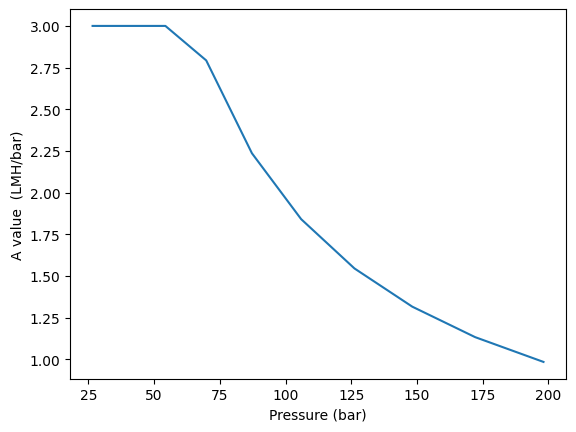

In [121]:

fig, ax = plt.subplots()
ax.plot(concentrations,pressures, label='Fixed A')
ax.plot(concentrations,pressures_with_a_loss, label='A as function of pressure')
ax.set(xlabel='Concentration (g/L)',ylabel='Pressure (bar)')
ax.legend()
fig, ax = plt.subplots()
ax.plot(pressures_with_a_loss,actual_a)
ax.set(xlabel='Pressure (bar)',ylabel='A value  (LMH/bar)')
plt.show()

### Replacing an existing constraint with a new one

A common uncertainty in membrane process is prediction of mass transport rates.

Current WaterTap model uses a corelation derived by Guillen et al from CFD simulation of 2D flow in RO channel with a circular spacers. The used corelation is shown below, as well as its implementation in RO model.

Current corelation is  Sh = 0.45*(Re*Sc)^0.36 

    @self.Constraint(
        self.flowsheet().config.time,
        self.length_domain,
        self.config.property_package.solute_set,
        doc="Sherwood number",
    )
    def eq_N_Sh_comp(b, t, x, j):
        return (
            b.N_Sh_comp[t, x, j]
            == 0.46 * (b.N_Re[t, x] * b.N_Sc_comp[t, x, j]) ** 0.36
        )

An alternative corelation that could be used has been derived by Schock & Miquel [Desalination, 1987, 64, 339-352] from experiments. This corelation has been shown to be potentially more accurate then the Guilen correlation [Dudchenko et al. ACS ES&T Engineering, https://doi.org/10.1021/acsestengg.1c00496]

Sh = 0.065 * Re^0.875 * Sc^0.33

Lets implement the Schock & Miquel correlation instead and observe its overall impact on process design.


In [122]:
# adding a variable so we can adjust magnitude of Sherwood correlation 
m.fs.SH_adjustment=Var(initialize=1)
m.fs.SH_adjustment.fix()

# defining new sherwood correlation 
@m.fs.RO.feed_side.Constraint(
    [0],
    m.fs.RO.length_domain,
    m.fs.properties.solute_set,
    doc="Sherwood number Schock & Miquel",
)
def eq_N_Sh_comp_S_and_M(b, t, x, j):
    return (
        b.N_Sh_comp[t, x, j]
        == (0.065 * b.N_Re[t, x]**0.875 * b.N_Sc_comp[t, x, j] ** 0.33) *m.fs.SH_adjustment
    )


### Check output of our new constraint against old 

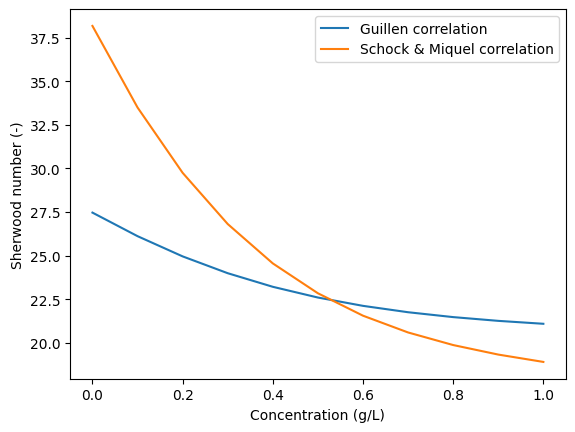

In [123]:
Guillen_sh=[]
Schock_sh=[]
module_position=[]

# grab values estimated for old correlation 
for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp:
    module_position.append(x)    
    Guillen_sh.append(m.fs.RO.feed_side.N_Sh_comp[t,x,j].value)
# grab values estimated for new correlation 
for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp:
    calculate_variable_from_constraint(m.fs.RO.feed_side.N_Sh_comp[t,x,j],m.fs.RO.feed_side.eq_N_Sh_comp_S_and_M[t,x,j])
    Schock_sh.append(m.fs.RO.feed_side.N_Sh_comp[t,x,j].value)

fig, ax = plt.subplots()
ax.plot(module_position,Guillen_sh, label='Guillen correlation')
ax.plot(module_position,Schock_sh, label='Schock & Miquel correlation')
ax.set(xlabel='Concentration (g/L)',ylabel='Sherwood number (-)')
ax.legend()

### Solve the model with new constraint

In [124]:
# Because the old and new Sherwood numbers have similar values (With 10x of each other)
# it is not necessary to initialize them

# Solve model with old correlation 
# make sure old constraint is active
m.fs.RO.feed_side.eq_N_Sh_comp.activate()
# make sure new constraint is NOT active
m.fs.RO.feed_side.eq_N_Sh_comp_S_and_M.deactivate()
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
result = solver.solve(m, tee=False)
water_flux_Guillen=[]
salt_flux_Guillen=[]
module_position=[]
# get water and salt flux estimated using Gulien correlation 
for (t,x,p,j) in m.fs.RO.flux_mass_phase_comp:
    if j=='H2O':
        water_flux_Guillen.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)
    if j=='TDS':
        salt_flux_Guillen.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)
        module_position.append(x)

# make sure old constraint is NOT active
m.fs.RO.feed_side.eq_N_Sh_comp.deactivate()
# make sure new constraint is active
m.fs.RO.feed_side.eq_N_Sh_comp_S_and_M.activate()
print('We have {} degrees of freedom and expect 0'.format(degrees_of_freedom(m)))
assert degrees_of_freedom(m) == 0
result = solver.solve(m, tee=False)
assert_optimal_termination(result)
water_flux_Schock=[]
salt_flux_Schock=[]
for (t,x,p,j) in m.fs.RO.flux_mass_phase_comp:
    if j=='H2O':
        water_flux_Schock.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)
    if j=='TDS':
        salt_flux_Schock.append(m.fs.RO.flux_mass_phase_comp[t,x,p,j].value*3600)



We have 0 degrees of freedom and expect 0
We have 0 degrees of freedom and expect 0


## Plot comparison of water and salt flux estimated using Guillen and Schock & Miquel correlation

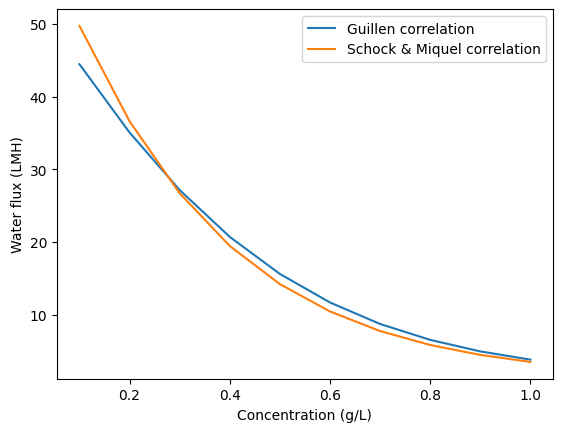

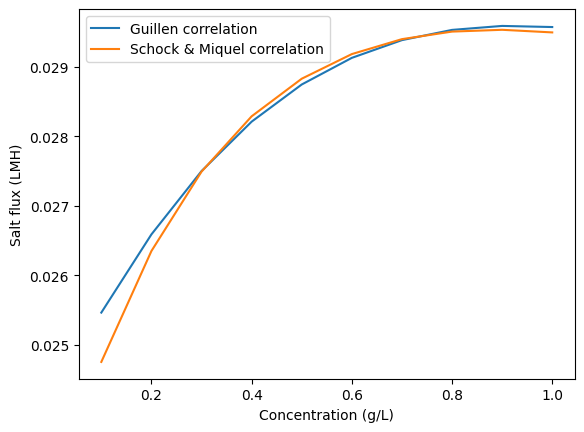

In [125]:


fig, ax = plt.subplots()
ax.plot(module_position,water_flux_Guillen, label='Guillen correlation')
ax.plot(module_position,water_flux_Schock, label='Schock & Miquel correlation')
ax.set(xlabel='Concentration (g/L)',ylabel='Water flux (LMH)')
ax.legend()
fig, ax = plt.subplots()
ax.plot(module_position,salt_flux_Guillen, label='Guillen correlation')
ax.plot(module_position,salt_flux_Schock, label='Schock & Miquel correlation')
ax.set(xlabel='Concentration (g/L)',ylabel='Salt flux (LMH)')
ax.legend()
plt.show()

### Lets explore how changing Sherwood number impacts result

In [126]:

adjustments = np.linspace(1,2,5)
pressure = []
avg_sh =[] 
for adj in adjustments:
    m.fs.SH_adjustment.fix(adj)
    assert degrees_of_freedom(m) == 0
    result =solver.solve(m, tee=False)
    pressure.append(m.fs.RO.inlet.pressure[0].value/1e5)
    sh_avg=np.average([m.fs.RO.feed_side.N_Sh_comp[t,x,j].value for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp])
    avg_sh.append(sh_avg)
    print("Solved adj {}".format(adj))

Solved adj 1.0
Solved adj 1.25
Solved adj 1.5
Solved adj 1.75
Solved adj 2.0


### Plot change in operating pressure vs. increase in overall mass transport rate 

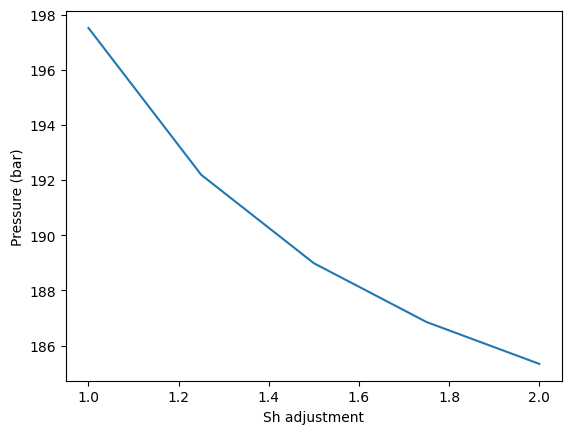

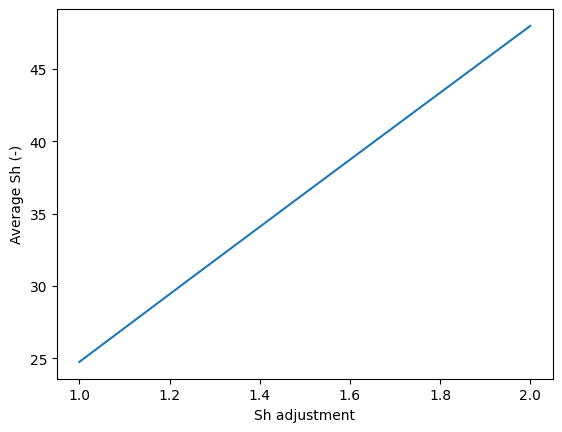

In [127]:
fig, ax = plt.subplots()
ax.plot(adjustments,pressure)
ax.set(xlabel='Sh adjustment',ylabel='Pressure (bar)')
fig, ax = plt.subplots()
ax.plot(adjustments,avg_sh)
ax.set(xlabel='Sh adjustment',ylabel='Average Sh (-)')
plt.show()

## Lets add costing

In [128]:
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

# add costing block
m.fs.costing = WaterTAPCosting()

# add Pump costing
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
# add RO costing
m.fs.RO.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
# Cost the process
m.fs.costing.cost_process()

# track water production rate 
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)

# add LCOW
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
# init our costing
m.fs.costing.initialize()

### Lets see how adjusting our Sh value impact process cost

In [129]:
# Lets explore how sh impacts cost 
adjustments = np.linspace(1,2,5)
pressure = []
avg_sh =[] 
lcow = []
for adj in adjustments:
    m.fs.SH_adjustment.fix(adj)
    assert degrees_of_freedom(m) == 0
    result =solver.solve(m, tee=False)
    pressure.append(m.fs.RO.inlet.pressure[0].value/1e5)
    sh_avg=np.average([m.fs.RO.feed_side.N_Sh_comp[t,x,j].value for (t,x,j) in m.fs.RO.feed_side.N_Sh_comp])
    avg_sh.append(sh_avg)
    lcow.append(m.fs.costing.LCOW.value)
    print("Solved adj {}".format(adj))

Solved adj 1.0
Solved adj 1.25
Solved adj 1.5
Solved adj 1.75
Solved adj 2.0


### Plot LCOW result

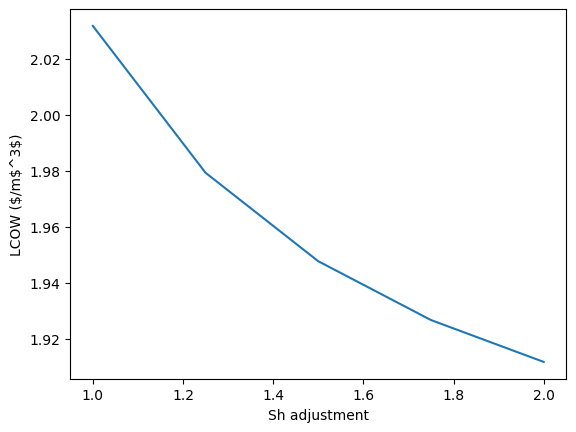

In [130]:
# plot LCOW result 
fig, ax = plt.subplots()
ax.plot(adjustments,lcow)
ax.set(xlabel='Sh adjustment',ylabel='LCOW ($/m$^3$)')
plt.show()

### Lets add a pressure factor to membrane cost

Typical pressure factor relate capital cost of component to operating pressure  

Here we will relate membrane cost to inlet pressure such that:

    Membrane cost = 30 $/m2 for RO inlet pressure < 60 bar 
    Membrane cost = 30* inlet pressure/ 60 bar for inlet pressure > 60 bar 


30


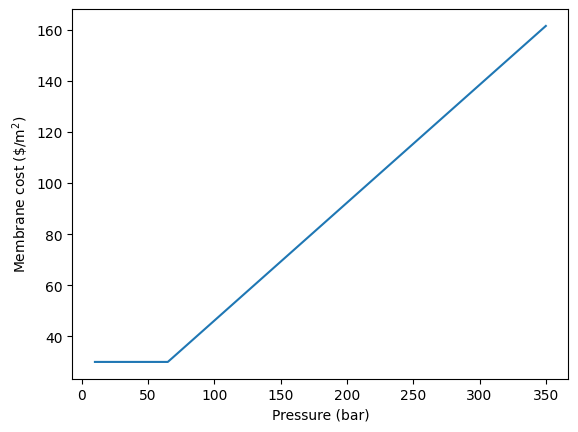

In [131]:
# add a pressure factor to membrane cost 
m.fs.base_membrane_cost=Var(initialize=30)
m.fs.base_membrane_cost.fix()
print(m.fs.base_membrane_cost.value)
set_scaling_factor(m.fs.base_membrane_cost, 1/m.fs.base_membrane_cost.value)

m.fs.RO_cost_pressure_constraint=(
    Constraint(expr=m.fs.costing.reverse_osmosis.membrane_cost==
    idaesMath.smooth_max(m.fs.base_membrane_cost,(m.fs.base_membrane_cost*(m.fs.RO.inlet.pressure[0]/(65*1e5))))))

m.fs.costing.reverse_osmosis.membrane_cost.unfix()
# Lets check that our function works and plot the result 
pressures_for_testing=np.linspace(10,350,100)
mem_cost=[]

for pressure in pressures_for_testing:
    m.fs.RO.inlet.pressure[0]=pressure*1e5 # needs to be in kPa
    calculate_variable_from_constraint(m.fs.costing.reverse_osmosis.membrane_cost,m.fs.RO_cost_pressure_constraint)
    mem_cost.append(m.fs.costing.reverse_osmosis.membrane_cost.value)
fig, ax = plt.subplots()
ax.plot(pressures_for_testing,mem_cost)
ax.set(xlabel='Pressure (bar)',ylabel='Membrane cost ($\$$/m$^2$)')
plt.show()

### Lets check how the new cost function impacts LCOW vs fixed membrane cost

In [132]:
# Lets explore how sh impacts cost 

concentrations = np.linspace(100,15,10)
pressures = []
lcow_fixed_mem_cost=[]
lcow_variable_mem_cost=[]
mem_cost=[]
pressures=[]
for con in concentrations:
    m.fs.feed.properties[0].conc_mass_phase_comp['Liq','TDS'].fix(con)
    m.fs.costing.reverse_osmosis.membrane_cost.fix(30)
    m.fs.RO_cost_pressure_constraint.deactivate()
    assert degrees_of_freedom(m) == 0
    result = solver.solve(m, tee=False)
    assert_optimal_termination(result)
    pressures.append(m.fs.RO.inlet.pressure[0].value/1e5)
    lcow_fixed_mem_cost.append(m.fs.costing.LCOW.value)
    m.fs.costing.reverse_osmosis.membrane_cost.unfix()
    m.fs.RO_cost_pressure_constraint.activate()
    assert degrees_of_freedom(m) == 0
    result =solver.solve(m, tee=False)
    assert_optimal_termination(result)
    lcow_variable_mem_cost.append(m.fs.costing.LCOW.value)
    mem_cost.append(m.fs.costing.reverse_osmosis.membrane_cost.value)
    print("Solved con {}".format(con))

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


RuntimeError: Solver failed to return an optimal solution. Solver status: warning, Termination condition: infeasible

### Lets plot LCOW with variable cost result

In [ ]:
# plot LCOW result 
fig, ax = plt.subplots()
ax.plot(pressures,lcow_fixed_mem_cost, label='Fixed membrane cost')
ax.plot(pressures,lcow_variable_mem_cost, label='Membrane cost as function of pressure')
ax.set(xlabel='Pressure (bar)',ylabel='LCOW ($\$$/m$^3$)')
plt.legend()

# plot membrane cost
fig, ax = plt.subplots()
ax.plot(pressures,mem_cost)
ax.set(xlabel='Pressure (bar)',ylabel='Membrane cost ($\$$/m$^2$)')
plt.show()